In [ ]:
import os
import pickle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

These functions are helpers that will train your models and visualize the results. You do not have to change them.

In [ ]:
def train_epoch(model, train_loader, optimizer, epoch, loss_key='total'):
    model.train()
    stats = defaultdict(list)
    for x in train_loader:
        x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_key)
        test_loss = eval_model(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def show_2d_latents(latents, labels, title='Latent Space'):
    plt.figure()
    plt.title(title)
    plt.scatter(latents[:, 0], latents[:, 1], s=1, c=labels)
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.show()

def show_2d_densities(densities, title='Densities'):
    plt.figure()
    plt.title(title)
    dx, dy = 0.025, 0.025
    x_lim = (-1.5, 2.5)
    y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.show()


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'], data['test']
    return train_data, test_data


def show_samples(samples, title, nrow=10):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title)

# Task 1: Autoregressive flows on 2d data

In this task you will train autoregressive flow mod on 2d data. Let generate and visualize train and test data.

In [ ]:
def generate_moons_data(count):
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels


def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title('train')
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax2.set_title('test')
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    plt.show()

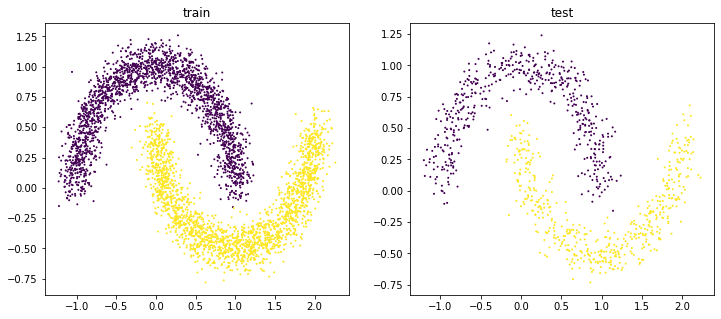

In [ ]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

Let define our model. We will you autoregressive flow model. 

You have to maximize log-likelihood (or equivalently minimize negative log-likelihood):
$$
    \log p(\mathbf{x} | \boldsymbol{\theta}) = \log p(\mathbf{z}) + \log \det \left| \frac{d \mathbf{z}}{d \mathbf{x}} \right|.
$$

The base distribution will be 2d Uniform: $\mathbf{z} \sim p(\mathbf{z}) = U[0, 1]$ (here $\mathbf{z} = (z_1, z_2)$).

Since we will you autoregressive model, the Jacobian will be triangular.

As we discussed in the lecture cumulative distribution function (CDF) of random variable is distributed uniformly. Thus, we will use CDF to map our data to the latent space. We assume that our data has mixture of gaussians distribution, which is defined by:
* $\mathbf{w}$ - weights of mixture components,
* $\boldsymbol{\mu}$ - locations (means) of each gaussian, 
* $\boldsymbol{\sigma}$ - standart deviations of each gaussian.

The mapping function is the following:
$$
    z_i = f(x_i, \mathbf{w}(x_{1:i-1}), \mu(x_{1:i-1}), \sigma(x_{1:i-1})).
$$
Here function $f$ is just CDF of gaussian mixture.

In [ ]:
class MixtureCDFFlow(nn.Module):
    def __init__(
        self, 
        n_components=4
    ):
        super().__init__()
        # this is a base distribution
        self.base_dist = Uniform(0.0, 1.0)
        # this is a distribution of one of the mixture component
        self.mixture_dist = Normal

        # define mixture parameters (location, log_scale, weights logits)
        # these parameters are trainable
        self.loc = 
        self.log_scale = 
        self.weight_logits = 
        self.n_components = n_components

    def forward(self, x):
        assert len(x.shape) == 1
        # to get weights of each component apply softmax to weight logits
        weights = 
        # find CDF value for each component .cdf() method of self.mixture_dist with self.loc and self.log_scale
        # (do not forget that scale is logarithmic)
        # then multiply the cdf for each gaussian to the mixture weights and sum these values across components
        cdf =
        z = torch.sum(cdf * weights, dim=1)

        # use .log_prob() method of self.mixture_dist, then exponentiate, multiply by weights and take logarithm
        log_prob = self.mixture_dist(self.loc, self.log_scale.exp()).log_prob(
            x.unsqueeze(1).repeat(1, self.n_components)
        )
        log_det = torch.sum(log_prob.exp() * weights, dim=1).log()

        return z, log_det


class FullyConnectedMLP(nn.Module):
    # do not change this class
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []
        prev_h = input_shape
        for h in hiddens:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_shape))
        self.net = nn.Sequential(*model)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, *self.output_shape)


class AutoregressiveFlow(nn.Module):
    def __init__(
        self, 
        mix_comp_z1=5,  
        mix_comp_z2=5,
        mlp_hiddens=[64, 64, 64]
    ):
        super().__init__()
        # define mixture cdf flow for first component of 2d distribuion
        self.dim1_flow = 
        # define mlp which has to return 3 set of parameters (w, mu, sigma)
        self.mlp = 
        self.mix_comp_z2 = mix_comp_z2

        # this is a base distribution
        self.base_dist = Uniform(torch.tensor(0.0).cuda(), torch.tensor(1.0).cuda())
        # this is a distribution of one of the mixture component
        self.mixture_dist = Normal

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        # apply mixture cdf flow to the x1
        z1, log_det1 = 
        
        # get parameters of second mixture component from mlp (applied to x1)
        loc, log_scale, weight_logits = 
        # get weights from logits (use softmax)
        weights = 

        # find CDF value for each component .cdf() method of self.mixture_dist with self.loc and self.log_scale
        # (do not forget that scale is logarithmic)
        # then multiply the cdf for each gaussian to the mixture weights and sum these values across components
        cdf = 
        z2 = torch.sum(cdf * weights, dim=1)

        # use .log_prob() method of self.mixture_dist, then exponentiate, multiply by weights and take logarithm
        log_prob = 
        log_det2 = torch.sum(log_prob * weights, dim=1).log()

        z = torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1)
        log_det = torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)
        return z, log_det

    def log_prob(self, x):
        # apply the model and compute log probability
        return 

    def loss(self, x):
        # loss is just negative value of log prob
        return {'total': -self.log_prob(x).mean()}

total: 0.5664


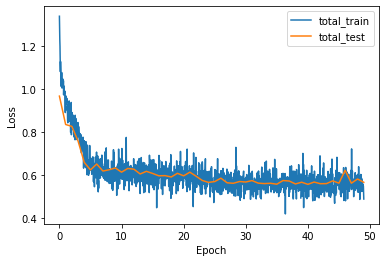

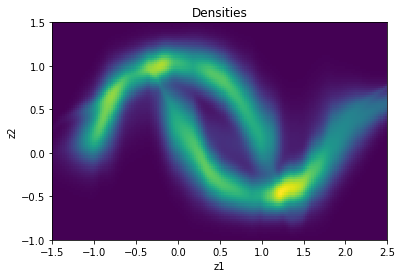

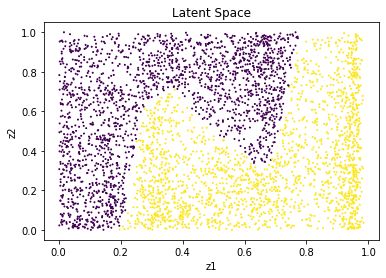

In [ ]:
BATCH_SIZE = 
EPOCHS = 
LR = 
MIX_COMP_Z1 = 
MIX_COMP_Z2 = 
MLP_HIDDENS = 

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

ar_flow = AutoregressiveFlow(
    mix_comp_z1=MIX_COMP_Z1,
    mix_comp_z2=MIX_COMP_Z2,
    mlp_hiddens=MLP_HIDDENS
).cuda()

train_losses, test_losses = train_model(ar_flow, train_loader, test_loader, epochs=EPOCHS, lr=LR)

dx, dy = 0.025, 0.025
x_lim = (-1.5, 2.5)
y_lim = (-1, 1.5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).cuda()
densities = np.exp(ar_flow.log_prob(mesh_xs).cpu().detach().numpy())

z, _ = ar_flow(torch.FloatTensor(train_data).cuda())
latents = z.cpu().detach().numpy()

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

plot_training_curves(train_losses, test_losses)
show_2d_densities(densities)
show_2d_latents(latents, train_labels)

# Task 2: VLAE on CIFAR10

In this task you will fit Variational Lossy Antoencoder model to the CIFAR10 dataset (https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing).  

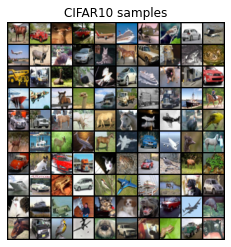

In [ ]:
train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM2020', 'homework_supplementary', 'cifar10.pkl'))
visualize_data(train_data, 'CIFAR10 samples')

The model consists of:
* convolutional encoder (variational posterior destrituion $q(\mathbf{z} | \mathbf{x})$)
* convolutional decoder $p(\mathbf{x} | \mathbf{z})$
* autoregressive prior

We will use MADE model for autoregressive prior. MADE Autoregressive frow (mapping from $z\rightarrow \epsilon$) should output location $\mu(z)$ and scale parameters $\sigma(z)$. The mapping from $z$ to $epsilon$ has the form:
$$
\epsilon = z * \sigma(z) + \mu(z)
$$

The ELBO objective in this task is:
$$
-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]
$$
where 
$$
\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}
$$



In [ ]:
class ConvEncoder(nn.Module):
    # do not change this class
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * n_latent)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std
        

class ConvDecoder(nn.Module):
    # do not change this class
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(n_latent, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        return self.deconvs(out)


class MaskedLinear(nn.Linear):
    # do not change this class
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    # do not change this class
    def __init__(self, input_shape, d, hidden_size=[512, 512]):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.nout = self.nin * d
        self.d = d
        self.hidden_sizes = hidden_size
        self.ordering = np.arange(self.nin)

        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()
        self.net = nn.ModuleList(self.net)

        self.m = {}
        self.create_mask()

    def create_mask(self):
        L = len(self.hidden_sizes)

        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(),
                                          self.nin - 1, size=self.hidden_sizes[l])

        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        batch_size = x.shape[0]
        out = x.view(batch_size, self.nin)
        for layer in self.net:
            out = layer(out)
        out = out.view(batch_size, self.nin, self.d)
        return out


class AFVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape
        self.latent_size = latent_size

        # define made model
        self.made = 
        # define conv encoder and decoder models
        self.encoder = 
        self.decoder = 

    def loss(self, x):
        x = 2 * x.float() - 1
        # apply encoder to x to get variational distribution parameters
        mu_z, log_std_z = 
        # sample z from variational distribution
        z = 
        # apply decoder to get reconstruction
        x_recon = 

        # reconstruction loss is just mse loss 
        recon_loss = 
        # enc log prob is log of normal distribution on z 
        enc_log_prob = 

        # apply MADE model to z
        out = 
        # split results 
        mu, log_std = out.chunk(2, dim=-1)
        # this trick is just for model stability (do not touch it)
        log_std = torch.tanh(log_std)
        mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
        # scale z to sigma and shift to mu get epsilon
        eps = z * torch.exp(log_std) + mu
        # compute prior log prob (log of standart normal)
        prior_log_prob = 

        # kl loss is difference between encoder log prob and prior log prob
        kl_loss = (enc_log_prob - prior_log_prob).sum(1).mean()
        return {
            'total': recon_loss + kl_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda()
            # investigate how to sample from autoregressive model (do not change this part)
            for i in range(self.latent_size):
                mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)
                log_std = torch.tanh(log_std)
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
            return self.decoder(z).cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

total: 245.4049
recon_loss: 217.2362
kl_loss: 28.1687


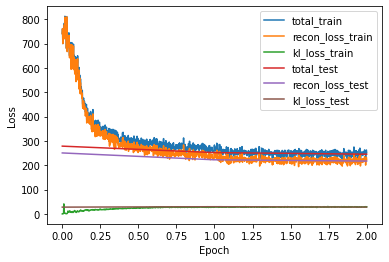

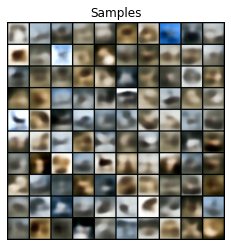

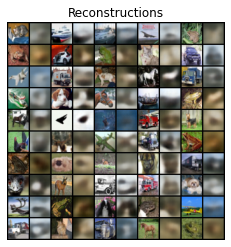

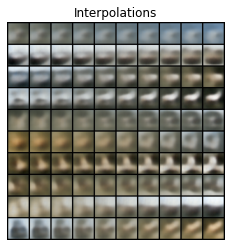

In [ ]:
BATCH_SIZE = 
EPOCHS = 
LR = 

train_data, test_data = load_pickle(os.path.join('drive', 'My Drive', 'DGM2020', 'homework_supplementary', 'cifar10.pkl'))

train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

model = AFVAE((3, 32, 32), 16).cuda()

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR)
samples = model.sample(100) * 255

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    z = model.encoder(2 * x - 1)[0]
    x_recon = model.decoder(z).cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
x = x.cpu().permute(0, 2, 3, 1).numpy()
reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    x = 2 * x - 1
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

samples, reconstructions, interps = np.clip(samples, 0, 255), np.clip(reconstructions, 0, 255), np.clip(interps, 0, 255)

samples, reconstructions, interps = samples.astype('float32'), reconstructions.astype('float32'), interps.astype('float32')
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')
show_samples(interps, title='Interpolations')